In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Load data**

In [ ]:
train_path = '/content/drive/MyDrive/MSc in DS & AI/Advanced AI/train.csv'

In [ ]:
df = pd.read_csv(train_path)

In [ ]:
# See the shape and head
print(df.shape)
print(df.head())

(4000, 19)
   CbRt  SGZ     P     Q  CrRl  AbRl  DfClb  DfRlRt  DfDfClb     ST1     ST2  \
0  -437   10 -0.34  0.15  -0.4   -20      4  -0.017     -0.4 -0.0013 -0.0016   
1  -282  -34 -0.40  0.00   0.3   -10     -5  -0.020      1.6 -0.0010 -0.0010   
2   -90  -20 -0.21 -0.02   0.2    -8      3  -0.004     -0.2 -0.0005 -0.0006   
3  -164    0  0.19  0.08   2.0   -11    -12  -0.009      0.5 -0.0009 -0.0008   
4     8  -36  0.41  0.09   1.8   -19      9  -0.022     -0.1 -0.0021 -0.0022   

      ST3     ST4   DfST1  DfST2   DfST3  DfST4      Sa  Target  
0 -0.0016 -0.0016  0.0003      0  0.0000      0 -0.0016   0.022  
1 -0.0010 -0.0010  0.0000      0  0.0000      0 -0.0010   0.016  
2 -0.0006 -0.0006  0.0000      0  0.0000      0 -0.0006   0.019  
3 -0.0008 -0.0008 -0.0002      0 -0.0001      0 -0.0008   0.017  
4 -0.0022 -0.0024  0.0001      0  0.0001      0 -0.0024   0.036  


##**2. Prepare Data for Modeling**

In [ ]:
# Separate features and target
X = df.drop("Target", axis=1).values
y = df["Target"].values

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#**3. Enable Dropout at Prediction Time (MC Sampling)**

In [ ]:
# Function to predict with MC Dropout
def mc_dropout_predict(model, X, n_samples=20):
    predictions = [model(X, training=True).numpy().flatten() for _ in range(n_samples)]
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0) * 2  # 95% confidence
    return mean_prediction, uncertainty

#**4. Build a Neural Network with MC Dropout**

In [ ]:
# Define the model with Dropout
def build_mc_dropout_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # Dropout kept ON at prediction time
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)  # Output: pitch
    ])
    return model

model = build_mc_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0836
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7709e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3089e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8094e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1163e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8437e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6310e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4304e-04
Epoch 15/50
100/100 ━━━━━━━━━

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.002760750611172989
Mean Squared Error: 1.7858725316709923e-05
R² Score: 0.65


In [ ]:
#Scenario 2: Increase Model Depth (add more hidden layers)

def build_deeper_mc_dropout_model(input_shape):
  model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

model = build_deeper_mc_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0338
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9230e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2008e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4845e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7997e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1225e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5215e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1731e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0688e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5213e-05
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3849e-05
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1156e-05
Epoch 15/50
1

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.0025130992024578157
Mean Squared Error: 1.648959846851072e-05
R² Score: 0.68


In [ ]:
#Scenario 3: Increase Width (more neurons in each layer)

def build_wider_mc_dropout_model(input_shape):
  model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

model = build_wider_mc_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0361
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7138e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4140e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0675e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4176e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7415e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6579e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0729e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0554e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8414e-05
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0431e-05
Epoch 15/50
100/1

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.0020042052540183066
Mean Squared Error: 7.1558950265696965e-06
R² Score: 0.86


In [ ]:
#Scenario 4: Add Batch Normalization (better training stability)

def build_bn_mc_dropout_model(input_shape):
  model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

model = build_bn_mc_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1690
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4546
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2898
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1630
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1066
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0662
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0420
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2699e-04
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.0036200005738250907
Mean Squared Error: 2.7103383961334753e-05
R² Score: 0.47


In [ ]:
# Scenario 5: Add EarlyStopping and Learning Rate Scheduler
def build_model_with_lr_scheduler(input_shape):
  model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

model = build_model_with_lr_scheduler(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, callbacks=[early_stop, lr_schedule], verbose=1)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0485 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2530e-04 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8621e-04 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3021e-04 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1417e-04 - learning_rate: 0.0010
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9094e-04 - learning_rate: 0.0010
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6285e-04 - learning_rate: 0.0010
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.0025660908640827984
Mean Squared Error: 1.4263045745717988e-05
R² Score: 0.72


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Step 1: Polynomial feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"After polynomial expansion: {X_train_poly.shape[1]}")

# Step 2: PCA to reduce dimensionality (e.g., keep 95% variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_poly)
X_test_pca = pca.transform(X_test_poly)

print(f"After PCA reduction: {X_train_pca.shape[1]}")

# Step 3: Define MC Dropout model for PCA features
def build_mc_dropout_model_pca(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

model_pca = build_mc_dropout_model_pca(X_train_pca.shape[1])
model_pca.compile(optimizer='adam', loss='mse')

# Step 4: Train model
model_pca.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_split=0.2)

Original features: 18
After polynomial expansion: 189
After PCA reduction: 41
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.3640 - val_loss: 0.0855
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6157 - val_loss: 0.0905
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3335 - val_loss: 0.0580
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3176 - val_loss: 0.0491
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1729 - val_loss: 0.0171
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1139 - val_loss: 0.0104
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1373 - val_loss: 0.0064
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1069 - val_loss: 0.0060
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493 - val_loss: 0.0041
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0444 - val_loss: 0.0035
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - val_loss:

In [ ]:
y_pred_mean, y_pred_uncertainty = mc_dropout_predict(model, X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 0.002536910116700456
Mean Squared Error: 1.3834762108131975e-05
R² Score: 0.73


#**5. Final Selected model**

In [ ]:
def build_wider_mc_dropout_model(input_shape):
  model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

model = build_wider_mc_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0555
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9532e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5183e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4019e-04
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2008e-04
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5493e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5996e-04
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8074e-04
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4701e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1084e-04
Epoch 15/50
100/100 ━

#**6. Further Evaluation**

In [ ]:
lower = y_pred_mean - 2 * y_pred_uncertainty
upper = y_pred_mean + 2 * y_pred_uncertainty
picp = np.mean((y_test >= lower) & (y_test <= upper))
print(f"Prediction Interval Coverage Probability (PICP): {picp}")

Prediction Interval Coverage Probability (PICP): 0.95875


In [ ]:
print("\nSample Predictions with Uncertainty:")
for i in range(5):
 print(f"Prediction: {y_pred_mean[i]:.2f} ± {y_pred_uncertainty[i]:.2f}, True: {y_test[i]:.2f}")


Sample Predictions with Uncertainty:
Prediction: 0.02 ± 0.01, True: 0.03
Prediction: 0.02 ± 0.00, True: 0.02
Prediction: 0.03 ± 0.01, True: 0.03
Prediction: 0.02 ± 0.00, True: 0.02
Prediction: 0.02 ± 0.00, True: 0.02


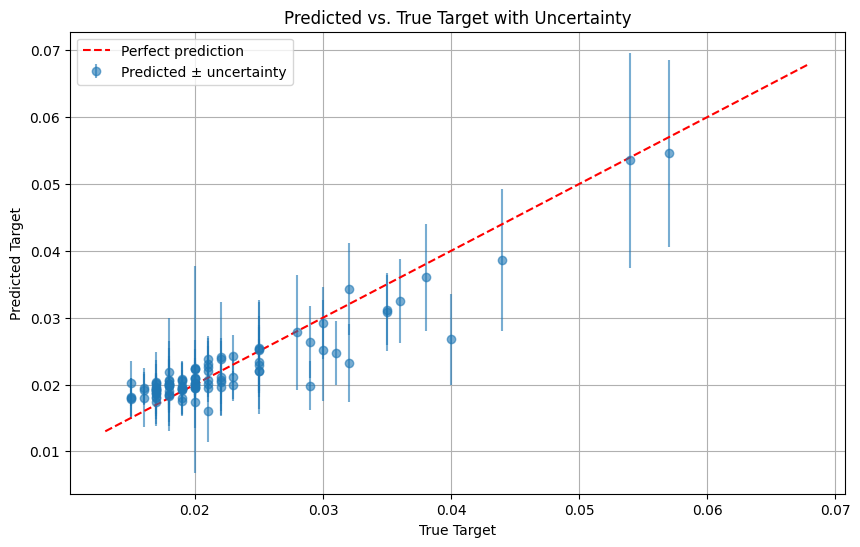

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(y_test[:100], y_pred_mean[:100], yerr=y_pred_uncertainty[:100], fmt='o', alpha=0.6, label='Predicted ± uncertainty')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.title('Predicted vs. True Target with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

#**8. Defining the Uncertainty Threshold for Rejection**

In [ ]:
# Function to get MC Dropout predictions + uncertainties
def mc_dropout_predict(model, X, n_samples=50):
    # Perform multiple forward passes with dropout active
    preds = np.array([model(X, training=True).numpy().flatten() for _ in range(n_samples)])
    mean_pred = preds.mean(axis=0)
    uncertainty = preds.std(axis=0) * 2  # 95% confidence interval approx.
    return mean_pred, uncertainty

# Predict on test set with uncertainty
mean_preds, uncertainties = mc_dropout_predict(model, X_test_scaled, n_samples=50)

# Define uncertainty threshold
threshold = 0.5

# ML with rejection: decide which predictions to accept or reject
final_predictions = []
rejected_indices = []

for i, (pred, uncert) in enumerate(zip(mean_preds, uncertainties)):
    if uncert > threshold:
        # Reject: abstain from prediction
        final_predictions.append(None)
        rejected_indices.append(i)
    else:
        final_predictions.append(pred)

# Example: handling accepted predictions (excluding rejected)
accepted_indices = [i for i in range(len(final_predictions)) if final_predictions[i] is not None]
accepted_preds = [final_predictions[i] for i in accepted_indices]
accepted_true = y_test[accepted_indices]

# Evaluate on accepted predictions only
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(accepted_true, accepted_preds)
mse = mean_squared_error(accepted_true, accepted_preds)
r2 = r2_score(accepted_true, accepted_preds)

print(f"MAE on accepted predictions: {mae:.4f}")
print(f"MSE on accepted predictions: {mse:.4f}")
print(f"R2 on accepted predictions: {r2:.4f}")

MAE on accepted predictions: 0.0021
MSE on accepted predictions: 0.0000
R2 on accepted predictions: 0.8409
